# Simple classification pipeline to check if everything works ok (no localization).

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import time
import ttach as tta

import models
import config
import dataset
import classification_transforms

In [2]:
start = time.time()

In [3]:
# setting seed
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# setting device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# just to check if everything works we only use the sample of all data
# set 'frac' in config to 1 to use all data
df = pd.read_csv(config.DF_PATH).sample(frac=config.frac) # <<<<---------------------------------------------
df.shape

(338, 16)

In [6]:
# create dfs
train_df = df[df.kfold.isin([0,1,2])].reset_index(drop=True)
valid_df = df[df.kfold==3].reset_index(drop=True)
test_df = df[df.kfold==4].reset_index(drop=True)

# create dataset
train_dataset = dataset.dataset(train_df, classification_transforms.train_transform)
valid_dataset = dataset.dataset(valid_df, classification_transforms.valid_transform)
test_dataset = dataset.dataset(test_df, classification_transforms.test_transform)

# create loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


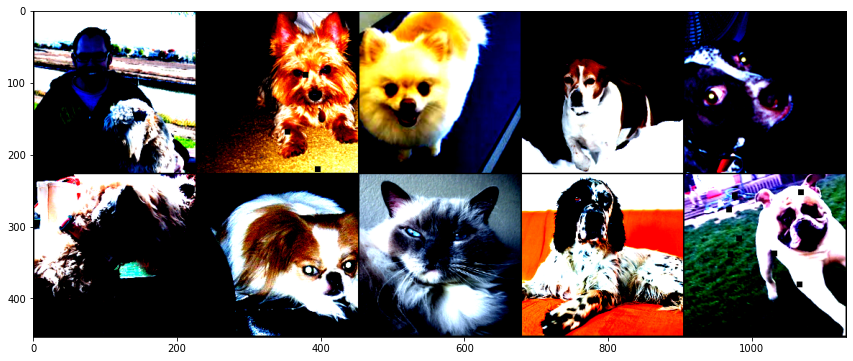

In [7]:
# displayig the data (looks this way because of normalization)
batch_tensor = next(iter(train_loader))[0][:10,...]
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)

# grid_img.shape
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1, 2, 0));

In [8]:
# check if all is good with the shapes of the loaders
print(f'dataloader test: {next(iter(train_loader))[0].shape}, {next(iter(valid_loader))[0].shape}')

dataloader test: torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224])


In [9]:
model = models.resnet18(2).to(device) # good
# model = models.vgg(2).to(device) # good
# model = models.alexnet(2).to(device) # bad

# loss
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)

In [10]:
def train_model(n_epochs=1,
                model=model,
                train_loader=train_loader,
                valid_loader=valid_loader,
                criterion=criterion,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler):


    '''
    Main function to train the model.
    '''
    
    total_time = time.time()
    print(f'================')
    print(f'started training...')
    
    for epoch in range(n_epochs):
        
        # train mode
        model.train()
        # start training time
        t0 = time.time()
        # these will be used for accuracy scores
        correct_on_epoch = 0
        total_num_images = 0
        epoch_loss = 0

        for batch, (images, labels) in enumerate(train_loader):
            # move images and labels to gpu, if available
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            # keep track of total images in one epoch
            total_num_images += images.size(0)
            # clear grads before forward pass
            optimizer.zero_grad()
            # outputs
            outputs = model(images)
            # get a prediction from outputs
            _, preds = torch.max(outputs, 1)
            # calculate the training loss
            loss = criterion(outputs, labels)
            # keep trach of total epoch loss
            epoch_loss += loss
            # keep track of correct predictions during each batch and add it to epoch's correct
            correct_on_epoch += (preds==labels).sum().item() # train acc
            # backward pass and step
            loss.backward()
            optimizer.step()
        # epoch train accuracy
        train_epoch_acc = round((correct_on_epoch/total_num_images), 4)
        # epoch train loss
        train_avg_epoch_loss = round(float(epoch_loss/len(train_loader)), 4)
        # epoch test loss and accuracy 
        valid_avg_epoch_loss, valid_epoch_accuracy = test_model(model, valid_loader)
        # total epoch time
        epoch_time = round(time.time() - t0)
        # learning scheduler step
        lr_scheduler.step()
        
        print(f'epoch: [{epoch+1}/{n_epochs}] | train loss: {train_avg_epoch_loss} | train acc: {train_epoch_acc} | valid loss: {valid_avg_epoch_loss} | valid acc: {valid_epoch_accuracy} | time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s')
    
    return model

In [11]:
def test_model(model, test_loader):
    '''
    Main function to test the model.
    '''
    model.eval()
    
    correct_on_epoch = 0
    total_num_images = 0
    epoch_loss = 0

    all_batch_acc = []
    
    with torch.no_grad():
        
        for batch, (images, labels) in enumerate(test_loader):
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            total_num_images += images.size(0)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)
            epoch_loss += loss

            correct_on_epoch += (preds==labels).sum().item()

    test_epoch_accuracy = round((correct_on_epoch/total_num_images), 4)
    test_avg_epoch_loss = round(float(epoch_loss/len(test_loader)), 4)
    
    return test_avg_epoch_loss, test_epoch_accuracy

In [12]:
# unfreeze all the params for training
def unfreeze(model=model):
    '''
    This finction will unfreeze previously freezed params of our model so all the model's params will be available for training.
    '''
    for param in model.parameters():
        param.requires_grad = True
    return model

In [13]:
%%time
# train a model with freezed params for a few epochs, unfreeze all params and train some more
train_model(config.frozen)
unfreeze()
train_model(config.unfrozen)
print('Training done.')

started training...
epoch: [1/1] | train loss: 0.6558 | train acc: 0.6244 | valid loss: 0.283 | valid acc: 0.9254 | time: 0m 17s
started training...
epoch: [1/1] | train loss: 0.2339 | train acc: 0.9512 | valid loss: 0.0345 | valid acc: 1.0 | time: 0m 35s
Training done.
Wall time: 51.7 s


In [14]:
# we can save pur model here for future inference
# checkpoint = {'model': model,
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, config.CLASS_MODEL_OUTPUT)

In [15]:
%%time
# testing with train data
_, train_acc = test_model(model, train_loader)
print(f'train set acc: {train_acc}')

train set acc: 0.9902
Wall time: 13.2 s


In [16]:
%%time
# testing with test data
_, test_acc = test_model(model, test_loader)
print(f'test set acc: {test_acc}')

test set acc: 0.9848
Wall time: 4.39 s


In [17]:
%%time
# this is a 5x tta with test data
tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform(config.tta_crop, config.tta_crop))

tta_dataset = dataset.dataset(valid_df, classification_transforms.tta_transform)
tta_loader = DataLoader(tta_dataset, batch_size=1, shuffle=False)

_, tta_acc = test_model(tta_model, tta_loader)

print(f'TTA acc: {tta_acc}')

TTA acc: 0.9851
Wall time: 25.4 s


In [18]:
total_time = time.time() - start
print(f'Total time: {total_time//60:.0f}m {total_time%60:.0f}s')

Total time: 1m 37s
